#**Maestría en Inteligencia Artificial Aplicada**

##**Curso: Proyecto Integrador**

###**Tecnológico de Monterrey**

###**Prof. Dra. Grettel Barceló Alonso**

### OSCAR MAURICIO BECERRA ALEGRÍA | A01795611

### VÍCTOR DANIEL BOHÓRQUEZ TORIBIO | A01794554

### ALAN JASSO ARENAS | A01383272

### EQUIPO 20


## **Avance 1. Análisis exploratorio de datos**
###**Proyecto de análisis y pronóstico epidemiológico de enfermedades neurológicas y trastornos mentales en México, con énfasis en la enfermedad de Parkinson (EP) durante 2014–2024**

**Drive de google.colab**

In [1]:
# Importamos y montamos Google Drive en '/content/drive'
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importación de librerías y utilidades para análisis temporal**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas para estadística y series de tiempo
!pip -q install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

Normalizamos el texto y configuramos el formato de visualización de los números.

In [3]:
import unicodedata
pd.options.display.float_format = "{:,.2f}".format

**Cargar Archivo**

In [ ]:
# Cargamos el archivo de Google Drive en un DataFrame de pandas
ruta = "/content/drive/MyDrive/Proyecto Integrador TEC 2025/EDA/data_parkinson.xlsx"
data_parkinson = pd.read_excel(ruta)

In [4]:
# Cargamos el archivo de Google Drive en un DataFrame de pandas
ruta = "/content/data_parkinson.xlsx"
data_parkinson = pd.read_excel(ruta)

Normalizamos los textos para mantener consistencia, convertimos Año a numérico para análisis temporal y transformamos Valor en entero reemplazando nulos por 0, ya que en los boletines representan semanas sin casos reportados.

In [5]:
# Normalización básica
data_parkinson.columns = data_parkinson.columns.str.strip()
for c in data_parkinson.select_dtypes(include='object').columns:
    data_parkinson[c] = data_parkinson[c].astype(str).str.strip()

# Tipos numéricos en Año
data_parkinson["Año"] = pd.to_numeric(data_parkinson["Año"], errors="coerce").astype("Int64")

# Convertir Valor a numérico y reemplazar nulos por 0
if "Valor" in data_parkinson.columns:
    data_parkinson["Valor"] = pd.to_numeric(data_parkinson["Valor"], errors="coerce").fillna(0).astype(int)

**Visión general del Dataset**

Visualizamos los nombres de las columnas del DataFrame.

In [6]:
print(data_parkinson.columns.tolist())

['Año', 'Semana', 'Pag.', 'Cuadro', 'No_01', 'Entidad', 'No_02', 'Padecimiento', 'Ax_001', 'Ax_002', 'Ax_003', 'No_03', 'Valor', 'No_04']


Visualizamos las dimensiones del dataset (filas y columnas), identifica el rango temporal (años y semanas), contabiliza el número de entidades y padecimientos, y resume la cardinalidad de columnas

### **¿Cuál es la cardinalidad de las variables categóricas?**


In [7]:
# Dimensiones del dataset
print("Dimensiones:", data_parkinson.shape)

# Rango temporal y conteos base
semana_num = None
if "Semana" in data_parkinson.columns:
    semana_num = pd.to_numeric(
        data_parkinson["Semana"].astype(str).str.extract(r"(\d+)")[0],
        errors="coerce"
    )

# Años numéricos
min_anio = max_anio = None
if "Año" in data_parkinson.columns:
    anios_numeric = pd.to_numeric(data_parkinson["Año"], errors="coerce")
    if pd.notna(anios_numeric.min()):
        min_anio = int(anios_numeric.min())
    if pd.notna(anios_numeric.max()):
        max_anio = int(anios_numeric.max())

# Rango de semanas
min_sem = max_sem = None
if semana_num is not None:
    if pd.notna(semana_num.min()):
        min_sem = int(semana_num.min())
    if pd.notna(semana_num.max()):
        max_sem = int(semana_num.max())

# Conteos de entidades y padecimientos
n_entidades = data_parkinson["Entidad"].nunique(dropna=True) if "Entidad" in data_parkinson.columns else None
n_padecimientos = data_parkinson["Padecimiento"].nunique(dropna=True) if "Padecimiento" in data_parkinson.columns else None

print(f"Rango de Años: {min_anio}–{max_anio}")
print(f"Rango de Semana (numérica): {min_sem}–{max_sem}")
print(f"N° Entidades: {n_entidades}")
print(f"N° Padecimientos: {n_padecimientos}")

# Resumen por año: min/max semana y cantidad de semanas únicas observadas
if ("Año" in data_parkinson.columns) and (semana_num is not None):
    tmp = pd.DataFrame({
        "Año": pd.to_numeric(data_parkinson["Año"], errors="coerce"),
        "Semana_num": semana_num
    }).dropna()
    if not tmp.empty:
        tmp["Año"] = tmp["Año"].astype(int)
        tmp["Semana_num"] = tmp["Semana_num"].astype(int)
        resumen_anual = (tmp.groupby("Año")["Semana_num"]
                           .agg(["min", "max", "nunique"])
                           .rename(columns={"nunique": "semanas_unicas"})
                           .reset_index())
        display(resumen_anual)

# Cardinalidad
cols_target = ['Año', 'Semana', 'Pag.', 'Cuadro', 'Entidad', 'Padecimiento',
               'Ax_001', 'Ax_002', 'Ax_003', 'Valor', 'No_04']

rows = []
for c in cols_target:
    if c in data_parkinson.columns:
        rows.append({"Columna": c, "Cardinalidad": int(data_parkinson[c].nunique(dropna=True))})
    else:
        rows.append({"Columna": c, "Cardinalidad": "No existe"})

cardinalidad_df = pd.DataFrame(rows, columns=["Columna", "Cardinalidad"])
display(cardinalidad_df)

Dimensiones: (329637, 14)
Rango de Años: 2014–2024
Rango de Semana (numérica): 1–53
N° Entidades: 34
N° Padecimientos: 18


,Año,min,max,semanas_unicas
0,2014,2,53,52
1,2015,1,52,52
2,2016,1,52,52
3,2017,1,52,52
4,2018,1,52,52
5,2019,1,52,52
6,2020,1,53,53
7,2021,1,52,52
8,2022,1,52,52
9,2023,1,52,52


,Columna,Cardinalidad
0,Año,11
1,Semana,53
2,Pag.,26
3,Cuadro,4
4,Entidad,34
5,Padecimiento,18
6,Ax_001,12
7,Ax_002,3
8,Ax_003,4
9,Valor,7732


Visualizamos los tipos de datos y la presencia de valores nulos en cada columna, esto nos permite comprender la estructura del dataset, detectar variables categóricas o numéricas.

In [8]:
# Tipos de datos y nulos
print("\nTipos de datos y nulos:")
print(data_parkinson.info())


Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329637 entries, 0 to 329636
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Año           329637 non-null  Int64  
 1   Semana        329637 non-null  object 
 2   Pag.          329637 non-null  int64  
 3   Cuadro        329637 non-null  object 
 4   No_01         0 non-null       float64
 5   Entidad       329637 non-null  object 
 6   No_02         0 non-null       float64
 7   Padecimiento  329637 non-null  object 
 8   Ax_001        329637 non-null  int64  
 9   Ax_002        329637 non-null  object 
 10  Ax_003        329637 non-null  object 
 11  No_03         0 non-null       float64
 12  Valor         329637 non-null  int64  
 13  No_04         0 non-null       float64
dtypes: Int64(1), float64(4), int64(3), object(6)
memory usage: 35.5+ MB
None


Visualizamos las primeras y últimas filas del DataFrame para obtener una vista preliminar de los registros, confirmar que los datos fueron cargados correctamente y detectar posibles inconsistencias en los valores al inicio o al final del dataset.

In [9]:
# Primeras y últimas filas
print("\nPrimeras filas:")
display(data_parkinson.head())

print("\nÚltimas filas:")
display(data_parkinson.tail())


Primeras filas:


,Año,Semana,Pag.,Cuadro,No_01,Entidad,No_02,Padecimiento,Ax_001,Ax_002,Ax_003,No_03,Valor,No_04
0,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,0,Sem.,NaN,1,NaN
1,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,Acum.,H,NaN,1,NaN
2,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,DepresiónCIE-10ª REV.F32,2014,Acum.,M,NaN,0,NaN
3,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,Enfermedad de Parkinson\nCIE-10ª REV.\nG20,2014,0,Sem.,NaN,0,NaN
4,2014,sem02,57,CUADRO 17.,NaN,Aguascalientes,NaN,Enfermedad de Parkinson\nCIE-10ª REV.\nG20,2014,Acum.,H,NaN,0,NaN



Últimas filas:


,Año,Semana,Pag.,Cuadro,No_01,Entidad,No_02,Padecimiento,Ax_001,Ax_002,Ax_003,No_03,Valor,No_04
329632,2024,sem52,75,CUADRO 17.3,NaN,TOTAL,NaN,Historia Personal de Lesión Autoinfligida\nInt...,2023,0,Acum.,NaN,7672,NaN
329633,2024,sem52,75,CUADRO 17.3,NaN,TOTAL,NaN,Otros Síntomas y Signos que Involucran el Esta...,2024,0,Sem.,NaN,49,NaN
329634,2024,sem52,75,CUADRO 17.3,NaN,TOTAL,NaN,Otros Síntomas y Signos que Involucran el Esta...,2024,Acum.,H,NaN,1101,NaN
329635,2024,sem52,75,CUADRO 17.3,NaN,TOTAL,NaN,Otros Síntomas y Signos que Involucran el Esta...,2024,Acum.,M,NaN,2483,NaN
329636,2024,sem52,75,CUADRO 17.3,NaN,TOTAL,NaN,Otros Síntomas y Signos que Involucran el Esta...,2023,0,Acum.,NaN,1913,NaN


Visualizamos las estadísticas descriptivas de las variables numéricas para analizar su comportamiento, identificando medidas de tendencia central y dispersión, así como variaciones en los casos y patrones iniciales.

### **¿Cuáles son las estadísticas resumidas del conjunto de datos?**


In [10]:
# Estadísticas numéricas
print("\nEstadísticas numéricas:")
display(data_parkinson.describe().T)


Estadísticas numéricas:


,count,mean,std,min,25%,50%,75%,max
Año,"329,637.00","2,020.55",3.28,"2,014.00","2,018.00","2,022.00","2,023.00","2,024.00"
Pag.,"329,637.00",65.59,6.24,55.00,60.00,64.00,71.00,81.00
No_01,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
No_02,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ax_001,"329,637.00","2,017.27",78.30,0.00,"2,017.00","2,021.00","2,023.00","2,024.00"
No_03,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Valor,"329,637.00",431.06,"3,598.70",0.00,2.00,14.00,82.00,"154,302.00"
No_04,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Visualizamos los valores únicos de las columnas categóricas, excluyendo padecimiento, para identificar la variedad de categorías presentes en el dataset, detectar posibles errores de codificación o duplicados.

In [11]:
# Analizar valores únicos en columnas categóricas (excepto 'Padecimiento')
print("\nValores únicos por columna (excepto 'Padecimiento'):\n")
for col in data_parkinson.columns:
    if data_parkinson[col].dtype == 'object' and col.lower() != 'padecimiento':
        unicos = data_parkinson[col].dropna().unique()
        print(f"\n Columna: {col}")
        print(f"Total únicos: {len(unicos)}")
        print(f"Algunos valores: {list(unicos[:10])}")


Valores únicos por columna (excepto 'Padecimiento'):


 Columna: Semana
Total únicos: 53
Algunos valores: ['sem02', 'sem03', 'sem04', 'sem05', 'sem06', 'sem07', 'sem08', 'sem09', 'sem10', 'sem11']

 Columna: Cuadro
Total únicos: 4
Algunos valores: ['CUADRO 17.', 'CUADRO 17.1', 'CUADRO 17.2', 'CUADRO 17.3']

 Columna: Entidad
Total únicos: 34
Algunos valores: ['Aguascalientes', 'Baja California', 'Baja California Sur', 'Campeche', 'Coahuila', 'Colima', 'Chiapas', 'Chihuahua', 'Distrito Federal', 'Durango']

 Columna: Ax_002
Total únicos: 3
Algunos valores: ['0', 'Acum.', '2022']

 Columna: Ax_003
Total únicos: 4
Algunos valores: ['Sem.', 'H', 'M', 'Acum.']


Estructura y limpieza: se recortan espacios en nombres de columnas y se eliminan variables irrelevantes (Pag., Cuadro, No_*, Ax_00*) que no aportan al análisis.

Renombrado: se renombran campos clave (Ax_003 → Sexo, Valor → Casos) para mejorar la legibilidad.

Filtrado: se eliminan filas agregadas (Entidad = "TOTAL") para evitar doble conteo y se unifican denominaciones territoriales ("Distrito Federal" → "Ciudad de México").

Normalización de categorías: se estandariza Sexo (sin puntos, sin espacios y en mayúsculas) y se limpia la columna Padecimiento (eliminando saltos de línea, espacios múltiples y corrigiendo el pegado con "CIE").

Conversión numérica: la columna Casos se transforma a formato numérico sin imputar valores, preservando nulos para su tratamiento posterior.

In [12]:
# Limpiar nombres de columnas
data_parkinson.columns = data_parkinson.columns.str.strip()

# Eliminar columnas innecesarias
cols_posibles = ['Pag.', 'Cuadro', 'No_01', 'No_02', 'No_03', 'No_04', 'Ax_002', 'Ax_001']
cols_drop = [c for c in cols_posibles if c in data_parkinson.columns]
data_parkinson = data_parkinson.drop(columns=cols_drop)

# Renombrar columnas si existen
rename_map = {}
if 'Ax_003' in data_parkinson.columns: rename_map['Ax_003'] = 'Sexo'
if 'Valor'  in data_parkinson.columns: rename_map['Valor']  = 'Casos'
if rename_map:
    data_parkinson = data_parkinson.rename(columns=rename_map)

# Eliminar filas con 'TOTAL' en Entidad y normalizar nombre
if 'Entidad' in data_parkinson.columns:
    data_parkinson["Entidad"] = data_parkinson["Entidad"].replace({"Distrito Federal": "Ciudad de México"})
    data_parkinson = data_parkinson[~data_parkinson["Entidad"].isin(["TOTAL"])]

# Normaliza 'Sexo'
if 'Sexo' in data_parkinson.columns:
    data_parkinson["Sexo"] = (data_parkinson["Sexo"].astype(str)
                              .str.strip()
                              .str.replace(r"\.", "", regex=True)
                              .str.replace(r"\s+", "", regex=True)
                              .str.upper())

# Limpiar y estandarizar el texto en la columna Padecimiento
def normalizar_texto(texto: str):
    if pd.isna(texto): return texto
    texto = str(texto).replace("\n", " ")
    texto = " ".join(texto.split())
    texto = texto.replace("CIE", " CIE")
    texto = unicodedata.normalize("NFKC", texto)
    return texto.strip()

if 'Padecimiento' in data_parkinson.columns:
    data_parkinson["Padecimiento"] = data_parkinson["Padecimiento"].apply(normalizar_texto)

# --- FILTRO: trabajar solo con Parkinson
if 'Padecimiento' in data_parkinson.columns:
    pat = r"(?i)\bparkinson\b|\bG20\b"
    n0 = len(data_parkinson)
    data_parkinson = data_parkinson[data_parkinson["Padecimiento"].str.contains(pat, na=False)].copy()
    print(f"Filas totales antes: {n0}  |  Parkinson después del filtro: {len(data_parkinson)}")
    print("Padecimientos únicos (post-filtro):",
          sorted(data_parkinson['Padecimiento'].dropna().unique().tolist())[:10])

# Casos a numérico
if 'Casos' in data_parkinson.columns:
    data_parkinson["Casos"] = pd.to_numeric(data_parkinson["Casos"], errors="coerce")

Filas totales antes: 319648  |  Parkinson después del filtro: 71520
Padecimientos únicos (post-filtro): ['Enfermedad de Parkinson  CIE-10a REV. G20']


**Visualizamos resultados**

In [13]:
data_parkinson.head(10)

,Año,Semana,Entidad,Padecimiento,Sexo,Casos
3,2014,sem02,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,SEM,0
4,2014,sem02,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,H,0
5,2014,sem02,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,M,0
12,2014,sem02,Baja California,Enfermedad de Parkinson CIE-10a REV. G20,SEM,1
13,2014,sem02,Baja California,Enfermedad de Parkinson CIE-10a REV. G20,H,1
14,2014,sem02,Baja California,Enfermedad de Parkinson CIE-10a REV. G20,M,0
21,2014,sem02,Baja California Sur,Enfermedad de Parkinson CIE-10a REV. G20,SEM,0
22,2014,sem02,Baja California Sur,Enfermedad de Parkinson CIE-10a REV. G20,H,0
23,2014,sem02,Baja California Sur,Enfermedad de Parkinson CIE-10a REV. G20,M,0
30,2014,sem02,Campeche,Enfermedad de Parkinson CIE-10a REV. G20,SEM,0


### **¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?**



**Reestructuración del dataset**

Se creó una copia del DataFrame original para preservar los datos sin modificaciones y se filtraron únicamente las categorías relevantes de **Sexo** (`SEM`, `Sem.`, `H`, `M`). La columna **Semana** fue transformada en un valor entero (**Semana_num**) y, junto con el **Año**, se utilizó para generar una columna **Fecha** en formato ISO, representando el lunes de cada semana epidemiológica.  

El dataset fue reestructurado mediante un **pivot** que organiza la información por **Año, Semana_num, Entidad y Padecimiento**, consolidando las métricas en tres columnas clave:  

- **Nuevos_Casos**: número de casos registrados en la semana.  
- **Acum_H**: acumulado de casos en hombres.  
- **Acum_M**: acumulado de casos en mujeres.  

Posteriormente, se ordenaron los registros por entidad, padecimiento y fecha; se detectaron y agregaron registros duplicados por clave temporal; se convirtieron las métricas a formato numérico preservando valores faltantes; y finalmente se recalcularon **Año** y **Semana_num** a partir de la columna **Fecha** para garantizar su consistencia.  

In [14]:
# Copia del dataset
df = data_parkinson.copy()

# Filtrar solo categorías relevantes en Sexo
df = df[df["Sexo"].isin(["SEM", "Sem.", "H", "M"])]

# Asegurar 'Casos' numérico
df["Casos"] = pd.to_numeric(df.get("Casos"), errors="coerce")

# Extraer número de semana como entero
if "Semana" in df.columns:
    df["Semana_num"] = (
        df["Semana"].astype(str).str.extract(r"(\d+)").astype(float).astype("Int64")
    )
else:
    df["Semana_num"] = pd.Series(pd.NA, index=df.index, dtype="Int64")

max_sem_por_anio = (
    df.dropna(subset=["Año", "Semana_num"])
      .groupby("Año")["Semana_num"]
      .max()
      .astype(int)
      .to_dict()
)

# Pivot
df_pivot = (
    df.pivot_table(
        index=["Año", "Semana_num", "Entidad", "Padecimiento"],
        columns="Sexo",
        values="Casos",
        aggfunc="sum"
    )
    .reset_index()
)

# Renombrar métricas y quitar la cabecera
rename_cols = {}
if "SEM"  in df_pivot.columns: rename_cols["SEM"]  = "Nuevos_Casos"
if "Sem." in df_pivot.columns: rename_cols["Sem."] = "Nuevos_Casos"
if "H"    in df_pivot.columns: rename_cols["H"]    = "Acum_H"
if "M"    in df_pivot.columns: rename_cols["M"]    = "Acum_M"
df_pivot = df_pivot.rename(columns=rename_cols)
df_pivot.columns.name = None

# Descarta semanas > máximo del año publicado por el boletín
mask_valid_sem = df_pivot.apply(
    lambda r: (pd.notna(r["Año"]) and pd.notna(r["Semana_num"]) and
               int(r["Semana_num"]) <= max_sem_por_anio.get(int(r["Año"]), 52)),
    axis=1
)
df_pivot = df_pivot[mask_valid_sem].copy()

# Construir 'Fecha' (lunes) a partir de Año/Semana_num usando formato ISO
iso_str = (
    df_pivot["Año"].astype(int).astype(str)
    + "-W" + df_pivot["Semana_num"].astype(int).astype(str).str.zfill(2)
    + "-1"
)
df_pivot["Fecha"] = pd.to_datetime(iso_str, format="%G-W%V-%u", errors="coerce")

# Orden y deduplicación por clave temporal
df_pivot = df_pivot.sort_values(["Entidad", "Padecimiento", "Fecha"]).reset_index(drop=True)
if df_pivot.duplicated(["Entidad", "Padecimiento", "Fecha"]).any():
    df_pivot = (
        df_pivot
        .groupby(["Entidad", "Padecimiento", "Fecha"], as_index=False)[["Nuevos_Casos", "Acum_H", "Acum_M"]]
        .sum()
    )

# Asegurar numéricos en métricas
for c in ["Nuevos_Casos", "Acum_H", "Acum_M"]:
    if c in df_pivot.columns:
        df_pivot[c] = pd.to_numeric(df_pivot[c], errors="coerce")

# Recalcular 'Año' y 'Semana_num' desde 'Fecha'
isocal = df_pivot["Fecha"].dt.isocalendar()
df_pivot["Año"] = isocal["year"].astype("Int64")
df_pivot["Semana_num"] = isocal["week"].astype("Int64")

# Reordenar columnas
cols = ["Año", "Semana_num", "Fecha", "Entidad", "Padecimiento", "Nuevos_Casos", "Acum_H", "Acum_M"]
df_pivot = df_pivot[[c for c in cols if c in df_pivot.columns]]

# Vista
df_pivot.head(10)

,Año,Semana_num,Fecha,Entidad,Padecimiento,Nuevos_Casos,Acum_H,Acum_M
0,2014,2,2014-01-06,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,0,0,0
1,2014,3,2014-01-13,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,0,0,0
2,2014,4,2014-01-20,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,1,0,1
3,2014,5,2014-01-27,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,0,0,1
4,2014,6,2014-02-03,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,0,0,1
5,2014,7,2014-02-10,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,0,0,1
6,2014,8,2014-02-17,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,0,0,1
7,2014,9,2014-02-24,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,1,0,2
8,2014,10,2014-03-03,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,0,0,2
9,2014,11,2014-03-10,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,0,0,2


**Faltantes**

In [15]:
# --- Faltantes semanales (GLOBAL) sin reindex duplicada ---
fechas_presentes = pd.DatetimeIndex(df_pivot["Fecha"].dropna().unique()).sort_values()
fechas_completas = pd.date_range(fechas_presentes.min(), fechas_presentes.max(), freq="W-MON")
faltantes = fechas_completas.difference(fechas_presentes)

print(f"Semanas esperadas: {len(fechas_completas)}")
print(f"Semanas presentes: {len(fechas_presentes)}")
print(f"Semanas faltantes (global): {len(faltantes)}")
print("Primeras faltantes:", list(faltantes[:5]))

Semanas esperadas: 573
Semanas presentes: 571
Semanas faltantes (global): 2
Primeras faltantes: [Timestamp('2015-12-28 00:00:00'), Timestamp('2024-03-04 00:00:00')]


El “faltante global” es sólo el borde 2015-12-28 (semana 53 ISO) que el boletín epidemiológico no incluye.

In [16]:
# --- Detalle de faltantes por AÑO ISO dentro de cada (Entidad, Padecimiento) ---
def faltantes_detalle_por_anio(df, group_cols=["Entidad","Padecimiento"]):
    base = df.dropna(subset=["Fecha"]).copy()
    out = []
    for keys, g in base.groupby(group_cols, dropna=False):
        iso = g["Fecha"].dt.isocalendar()
        g = g.assign(Año_iso=iso["year"].astype(int),
                     Semana_iso=iso["week"].astype(int))
        for y, gy in g.groupby("Año_iso"):
            pres = sorted(gy["Semana_iso"].unique())
            if not pres:
                continue
            mn, mx = min(pres), max(pres)          # esperamos sólo el rango observado del año
            esperadas = set(range(mn, mx + 1))     # evita contar la semana 53 si no se publicó
            miss = sorted(esperadas - set(pres))
            for w in miss:
                fecha = pd.to_datetime(f"{y}-W{w:02d}-1", format="%G-W%V-%u")
                row = dict(zip(group_cols, keys))
                row.update({"Año_iso": y, "Semana_iso": w, "Fecha_Lunes": fecha})
                out.append(row)
    return (pd.DataFrame(out)
              .sort_values(["Año_iso","Semana_iso"] + group_cols)
              .reset_index(drop=True))

# Uso:
detalle = faltantes_detalle_por_anio(df_pivot, ["Entidad","Padecimiento"])
display(detalle.head(20))
print("Total faltantes internos por año:", len(detalle))

,Entidad,Padecimiento,Año_iso,Semana_iso,Fecha_Lunes
0,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
1,Baja California,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
2,Baja California Sur,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
3,Campeche,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
4,Chiapas,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
5,Chihuahua,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
6,Ciudad de México,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
7,Coahuila,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
8,Colima,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04
9,Durango,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04


Total faltantes internos por año: 32


In [17]:
# Filtros rápidos para buscar en boletines
# Por Año y Semana
detalle_2017_w10 = detalle[(detalle["Año_iso"] == 2017) & (detalle["Semana_iso"] == 10)]
display(detalle_2017_w10)

# 2) Por Entidad y Padecimiento
detalle_cd_mex_parkinson = detalle[
    (detalle["Entidad"] == "Ciudad de México") &
    (detalle["Padecimiento"].str.contains("Parkinson", case=False, na=False))
]
display(detalle_cd_mex_parkinson.head(20))

,Entidad,Padecimiento,Año_iso,Semana_iso,Fecha_Lunes


,Entidad,Padecimiento,Año_iso,Semana_iso,Fecha_Lunes
6,Ciudad de México,Enfermedad de Parkinson CIE-10a REV. G20,2024,10,2024-03-04


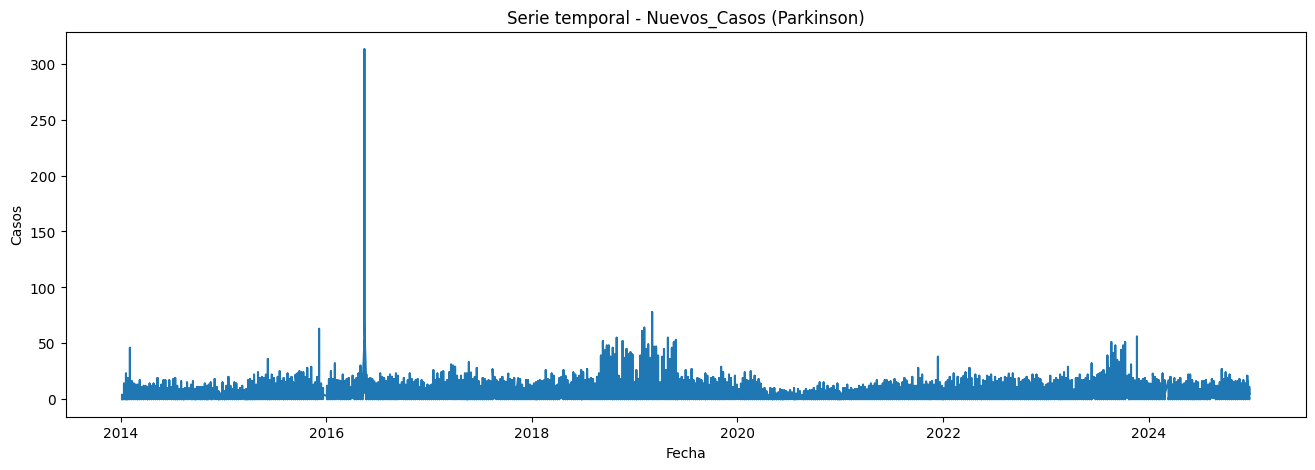

In [18]:
# Serie temporal simple: Nuevos_Casos
metrica = next((c for c in ["Nuevos_Casos", "Acum_H", "Acum_M"] if c in df_pivot.columns), None)

filtro = (df_pivot[df_pivot["Padecimiento"].str.contains("Parkinson", case=False, na=False)]
          .sort_values("Fecha")
          .copy())

plt.figure(figsize=(16,5))
plt.plot(filtro["Fecha"], filtro[metrica] if metrica else 0)
plt.title(f"Serie temporal - {metrica or 'Métrica no disponible'} (Parkinson)")
plt.xlabel("Fecha"); plt.ylabel("Casos")
plt.show()

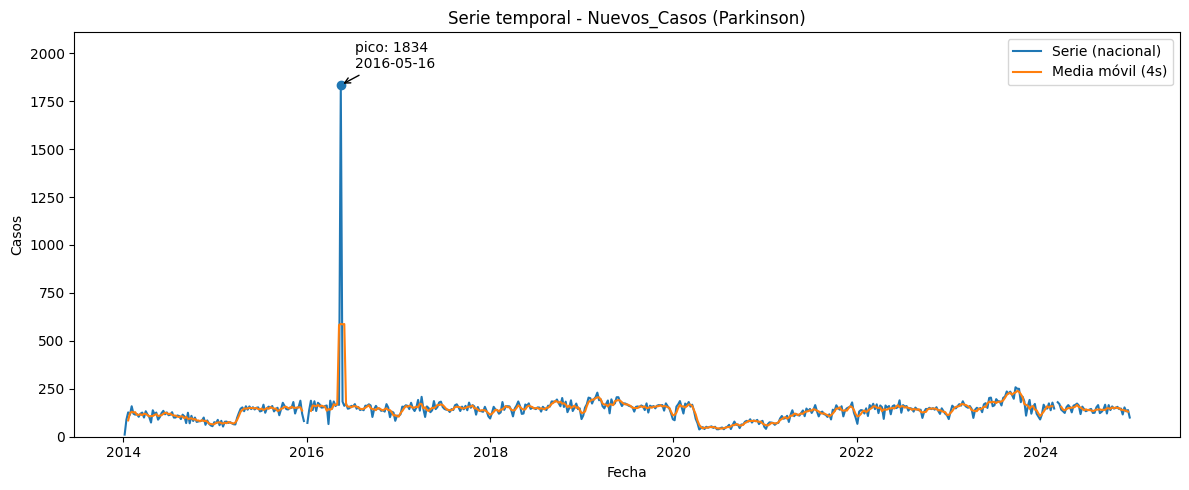

In [19]:
# Serie nacional agregada + suavizado + anotación del mayor pico (con aire)
metrica = next((c for c in ["Nuevos_Casos", "Acum_H", "Acum_M"] if c in df_pivot.columns), None)

filtro = (df_pivot[df_pivot["Padecimiento"].str.contains("Parkinson", case=False, na=False)]
          .loc[:, ["Fecha", metrica]]
          .dropna()
          .sort_values("Fecha"))

serie = (filtro.groupby("Fecha")[metrica].sum()
               .asfreq("W-MON"))

roll4 = serie.rolling(4, center=True).mean()

peak_date = serie.idxmax()
peak_val  = float(serie.loc[peak_date])

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(serie.index, serie.values, label="Serie (nacional)")
ax.plot(roll4.index, roll4.values, label="Media móvil (4s)")

# 1) Da “headroom” arriba para que no se corte la etiqueta
top_pad = max(10, peak_val * 0.15)        # 15% o al menos 10 unidades
ax.set_ylim(bottom=0, top=peak_val + top_pad)

# 2) Marca el pico
ax.scatter([peak_date], [peak_val], zorder=3)

# 3) Anota con offset y cajita para legibilidad
ax.annotate(
    f"pico: {int(peak_val)}\n{peak_date.date()}",
    xy=(peak_date, peak_val),
    xytext=(10, 10),               # mueve la etiqueta 10 pts a la derecha y 10 pts arriba
    textcoords="offset points",
    ha="left", va="bottom",
    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.85, lw=0),
    arrowprops=dict(arrowstyle="->", lw=1),
    annotation_clip=False          # por si el texto quedara fuera del axis
)

ax.set_title(f"Serie temporal - {metrica} (Parkinson)")
ax.set_xlabel("Fecha")
ax.set_ylabel("Casos")
ax.legend()
plt.tight_layout()
plt.show()

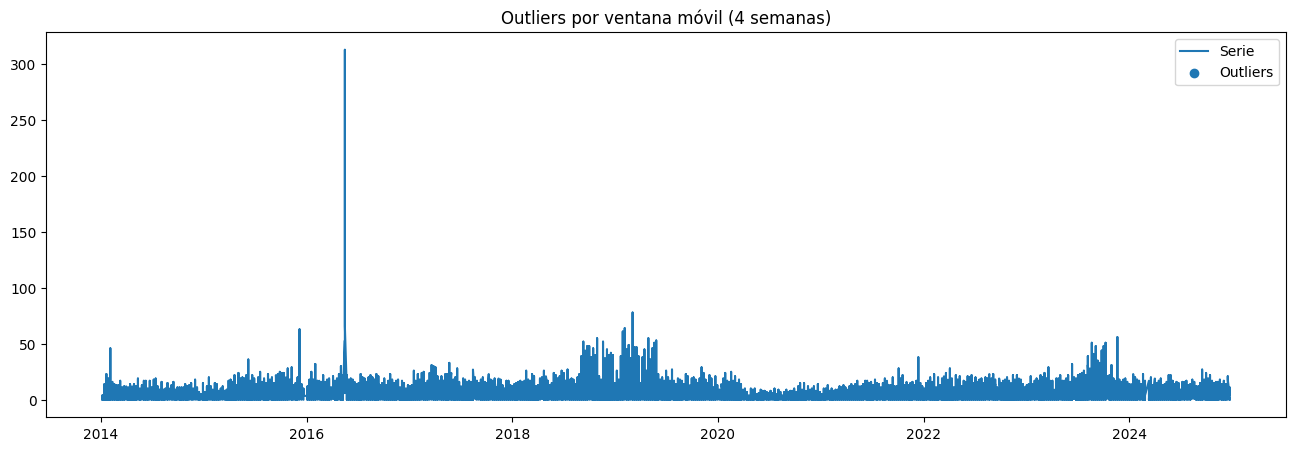

In [20]:
# Outliers por rolling mean ± 2*std
if metrica:
    filtro["rolling_mean"] = filtro[metrica].rolling(window=4, center=True).mean()
    filtro["rolling_std"]  = filtro[metrica].rolling(window=4, center=True).std()
    filtro["outlier"] = (
        (filtro[metrica] > filtro["rolling_mean"] + 2*filtro["rolling_std"]) |
        (filtro[metrica] < filtro["rolling_mean"] - 2*filtro["rolling_std"])
    )

    plt.figure(figsize=(16,5))
    plt.plot(filtro["Fecha"], filtro[metrica], label="Serie")
    plt.scatter(filtro.loc[filtro["outlier"], "Fecha"],
                filtro.loc[filtro["outlier"], metrica], label="Outliers")
    plt.title("Outliers por ventana móvil (4 semanas)")
    plt.legend(); plt.show()
else:
    print("No hay métrica disponible para detectar outliers.")

### **¿Hay valores atípicos en el conjunto de datos?**

Si se logran identificar casos atípicos en el dataset, siendo principalmente el aumento exponencial en el año 2016 y 2019, principalmente debido a pandemia. En los meses se puede notar valores atípicos, siendo el mes de Mayo el mes con mayores casos nuevos detectados, seguido por Marzo, Febrero y Diciembre.



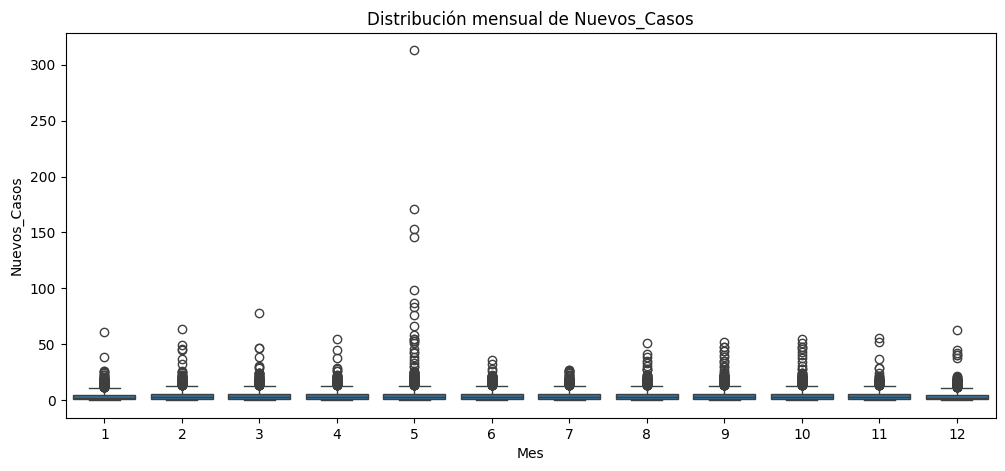

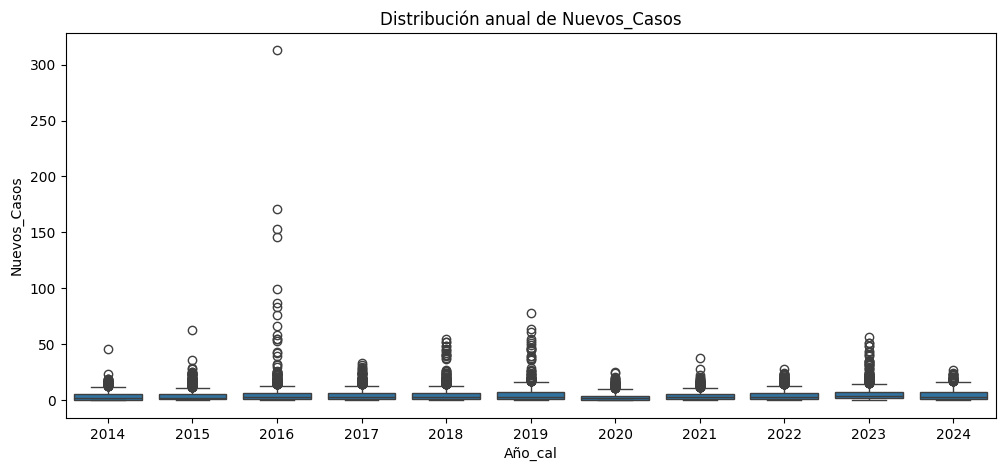

In [21]:
# --- Boxplots por Mes / Año ---
if metrica:
    df_box = df_pivot.copy()
    df_box["Mes"] = df_box["Fecha"].dt.month
    df_box["Año_cal"] = df_box["Fecha"].dt.year

    plt.figure(figsize=(12,5))
    sns.boxplot(x="Mes", y=metrica, data=df_box)
    plt.title(f"Distribución mensual de {metrica}")
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(x="Año_cal", y=metrica, data=df_box)
    plt.title(f"Distribución anual de {metrica}")
    plt.show()

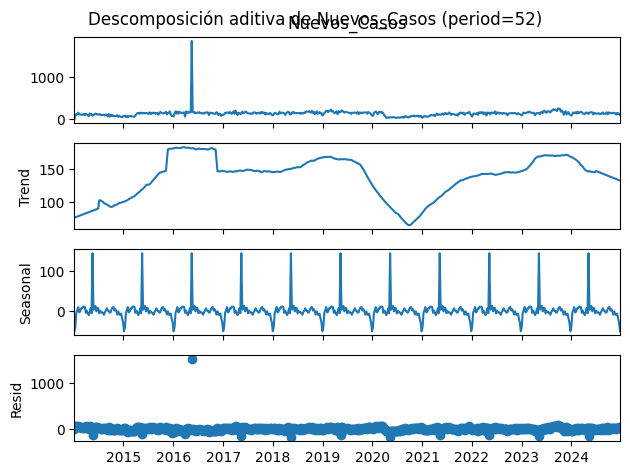

ADF: stat=-6.329, p-value=0.0000
KPSS: stat=0.199, p-value=0.1000


/tmp/ipython-input-1277829878.py:41: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(serie_drop, regression="c", nlags="auto")


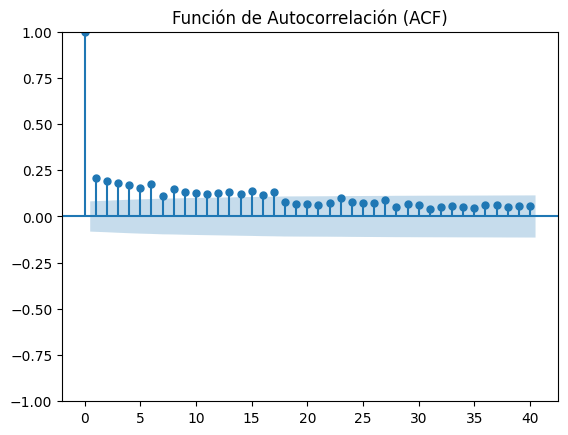

In [22]:
# Descomposición estacional (tendencia/estacionalidad/residuo)
if metrica:
    # Tomar solo Fecha + métrica y asegurar tipos válidos
    base = filtro[["Fecha", metrica]].copy()
    base["Fecha"] = pd.to_datetime(base["Fecha"], errors="coerce")
    base[metrica] = pd.to_numeric(base[metrica], errors="coerce")
    base = base.dropna(subset=["Fecha", metrica])

    # Agregar por fecha (elimina duplicados en el índice)
    serie = (base.groupby("Fecha", as_index=True)[metrica]
                  .sum()                  # usa .mean() si prefieres promediar
                  .sort_index())

    # Reindexar a semanal (lunes) y rellenar suavemente huecos
    full_idx = pd.date_range(serie.index.min(), serie.index.max(), freq="W-MON")
    serie = serie.reindex(full_idx)
    try:
        serie = serie.interpolate(method="time", limit_direction="both")
    except Exception:
        serie = serie.ffill().bfill()
    serie.name = metrica

    # Descomposición (periodo ~ 52 semanas)
    if serie.notna().sum() >= 2*52:
        decomp = seasonal_decompose(serie, model="additive", period=52, extrapolate_trend="freq")
        decomp.plot()
        plt.suptitle(f"Descomposición aditiva de {metrica} (period=52)")
        plt.show()
    else:
        print("Serie demasiado corta o con muchos NaN para descomposición (se requieren ≈104 observaciones útiles).")

    # Pruebas de estacionaridad y ACF ---
    serie_drop = serie.dropna()
    if len(serie_drop) > 12:
        # ADF
        adf_stat, adf_p, *_ = adfuller(serie_drop)
        print(f"ADF: stat={adf_stat:.3f}, p-value={adf_p:.4f}")

        # KPSS (puede fallar con algunas series; capturamos el error)
        try:
            kpss_stat, kpss_p, *_ = kpss(serie_drop, regression="c", nlags="auto")
            print(f"KPSS: stat={kpss_stat:.3f}, p-value={kpss_p:.4f}")
        except Exception as e:
            print("KPSS no disponible:", e)

        # ACF (ajusta lags a tamaño de la serie)
        max_lags = max(10, min(40, len(serie_drop)//2 - 1))
        plot_acf(serie_drop, lags=max_lags)
        plt.title("Función de Autocorrelación (ACF)")
        plt.show()
    else:
        print("Serie demasiado corta para ADF/KPSS/ACF.")
else:
    print("No hay métrica disponible para descomposición y pruebas.")

**Comentarios importantes de los datos a partir del conocimiento del negocio**

El incremento de registros en 2023 y 2024 se explica por un cambio estructural en el Boletín Epidemiológico, que dejó de centrarse únicamente en un grupo reducido de enfermedades transmisibles para ampliar su cobertura hacia un espectro más diverso, lo que genera un mayor volumen de casos reportados tanto a nivel semanal como anual.

La semana 1 presenta menos registros debido a que el comienzo del análisis es a partir de la semana 2 del año 2014.

La semana 53 presenta menos registros porque corresponde a una semana excepcional e incompleta dentro del calendario epidemiológico.

# Gráficas

**Matríz de correlación**

Se generó una matriz de correlación entre variables epidemiológicas para analizar la relación lineal entre los indicadores numéricos del dataset. Esta visualización permite:

- Confirmar la consistencia interna de los datos, verificando que los acumulados en hombres y mujeres se relacionen estrechamente con los nuevos casos.  
- Identificar la simetría en el comportamiento epidemiológico entre sexos, al observar correlaciones altas entre `Acum_H` y `Acum_M`.  
- Evaluar la influencia del tiempo sobre los casos, mostrando que no
  existe una relación lineal fuerte con la incidencia registrada.

### **¿Hay correlación entre las variables dependientes e independientes?**

Si hay una correlación entre las variables de nuevos casos y el sexo del paciente. Lo que se logra mostrar es que aunque si hay una diferencia no muy significativa en el aumento de nuevos casos para hombres y mujeres, con muy poca diferencia, indica que el incremento no depende tanto del sexo pero si hay una ligera diferencia entre los casos de hombres y mujeres, las mujeres pareciendo estar ligeramente más expuestas a ello.

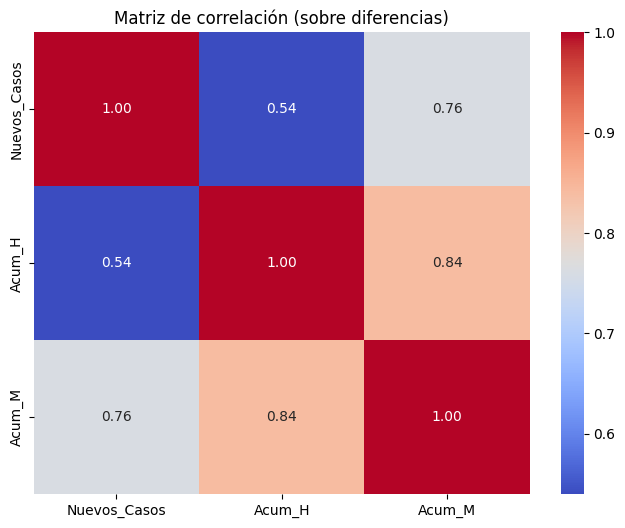

In [23]:
# Matriz de correlación (diferencias para atenuar tendencia/autocorrelación)
num_cols = ["Nuevos_Casos","Acum_H","Acum_M"]
corr_df = df_pivot[num_cols].diff().corr(min_periods=30)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación (sobre diferencias)")
plt.show()

Se generaron gráficas de distribución para analizar la frecuencia de registros y valores en las principales variables del dataset epidemiológico:

- **Semana epidemiológica (Semana_num):** la mayoría de las semanas presentan un número uniforme de registros, salvo la semana 1 (menor cantidad), la semana 10 (ligera caída) y la semana 53 (muy baja), lo cual se relaciona con características del calendario epidemiológico.
- **Año:** los registros se mantienen estables entre 2014 y 2022, mientras que en 2023 y 2024 se observa un aumento considerable.
- **Nuevos_Casos:** la distribución está fuertemente sesgada a la derecha; la mayoría de registros corresponden a valores bajos (0–4 casos), mientras que los valores altos son poco frecuentes y corresponden a eventos atípicos.
- **Acum_H y Acum_M:** ambos acumulados muestran un patrón similar al de los nuevos casos, con gran concentración en valores bajos y colas largas hacia la derecha. Se observa que los acumulados en mujeres (`Acum_M`) presentan mayor dispersión que en hombres (`Acum_H`).

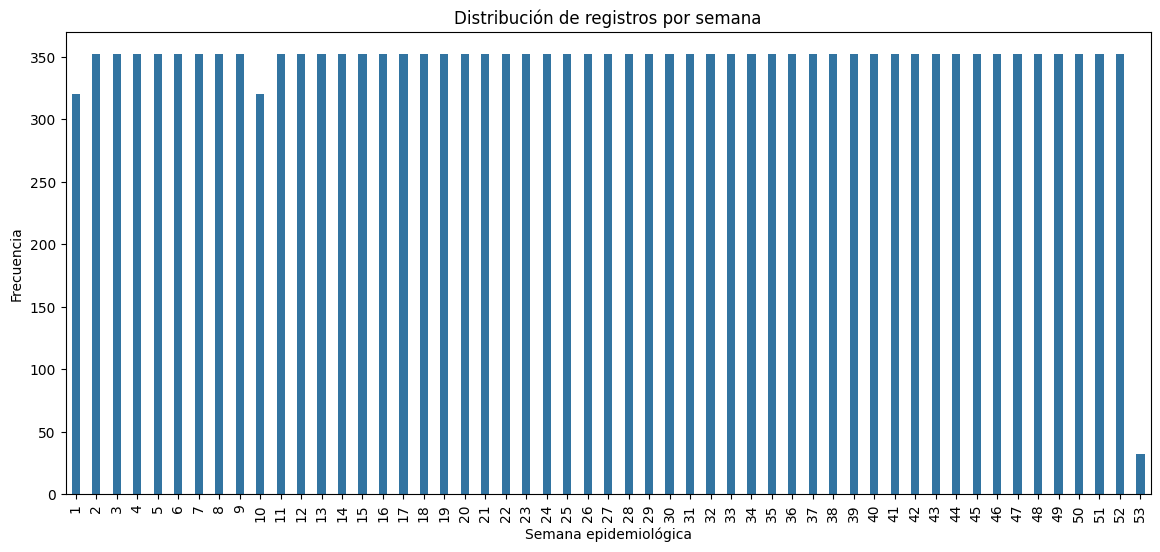

In [24]:
plt.figure(figsize=(14,6))
sns.countplot(
    x="Semana_num",
    data=df_pivot,
    order=sorted(df_pivot["Semana_num"].dropna().unique()),
    width=0.4
)
plt.title("Distribución de registros por semana")
plt.xlabel("Semana epidemiológica")
plt.ylabel("Frecuencia")
plt.xticks(rotation=90)
plt.show()

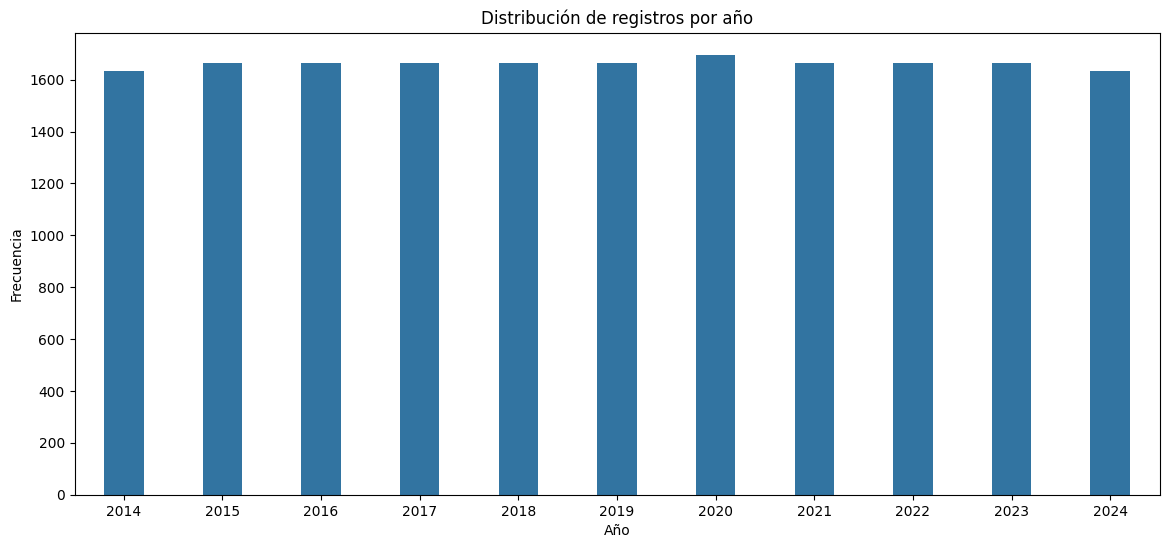

In [25]:
plt.figure(figsize=(14,6))
sns.countplot(
    x="Año",
    data=df_pivot,
    order=sorted(df_pivot["Año"].dropna().unique()),
    width=0.4
)
plt.title("Distribución de registros por año")
plt.xlabel("Año")
plt.ylabel("Frecuencia")
plt.show()

### **¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo).**

Con la información obtenida del dataset se puede detectar incrementos y decrementos de casos de Parkinson variados a lo largo de los años. No se encuentra una tendencia donde en cierto año o incluso mes es cuando aumentan los casos de esta enfermedad. Lo que si se identifica es un aumento significativo durante los años de pandemia llegando hasta más de 50 casos por el año 2019.

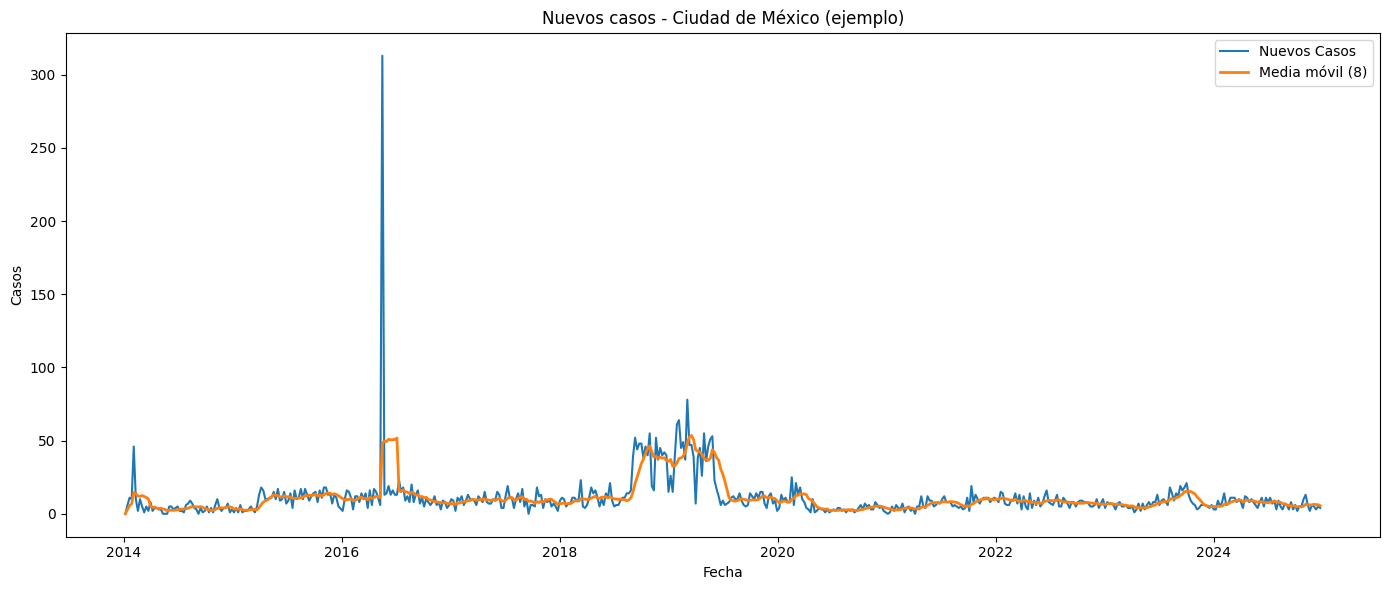

In [26]:
# Ejemplo de serie temporal para una Entidad/Padecimiento
ej = df_pivot[
    (df_pivot["Entidad"]=="Ciudad de México") &
    (df_pivot["Padecimiento"].str.contains("Parkinson", case=False, na=False))
].sort_values("Fecha").copy()

if not ej.empty:
    ej["MA_8"] = ej["Nuevos_Casos"].rolling(8, min_periods=1).mean()

    plt.figure(figsize=(14,6))
    plt.plot(ej["Fecha"], ej["Nuevos_Casos"], label="Nuevos Casos")
    plt.plot(ej["Fecha"], ej["MA_8"], label="Media móvil (8)", linewidth=2)
    plt.title("Nuevos casos - Ciudad de México (ejemplo)")
    plt.xlabel("Fecha"); plt.ylabel("Casos")
    plt.legend(); plt.tight_layout()
    plt.show()

### **¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?**

Está la distribución sesgada para la variable de nuevos casos como un sesgo positivo debido al aumento de casos y aunque los casos se mantienen lo más estables posibles, si llega a haber aumentos en algunos años pero sin mostrar un incremento tan grande como en 2016 y 2019.

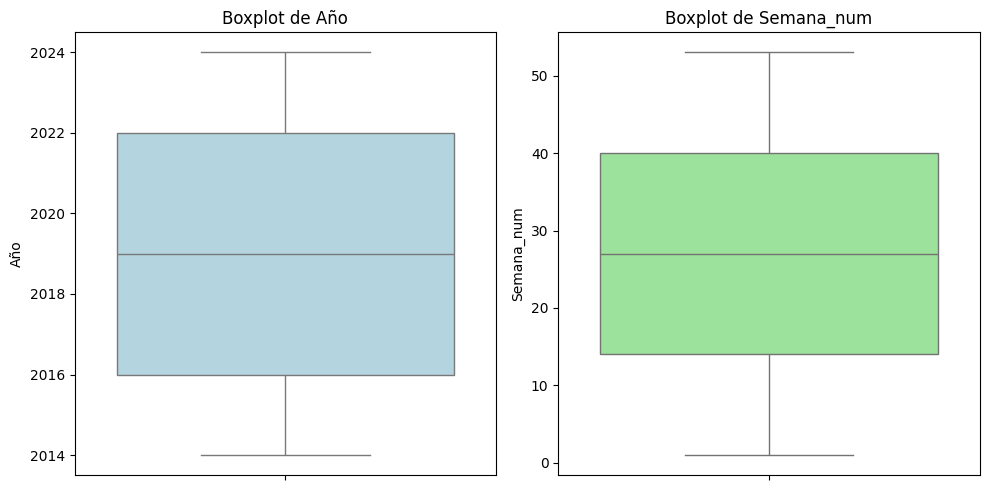

In [27]:
# Fila 1: Año y Semana_num
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_pivot["Año"], color="lightblue")
plt.title("Boxplot de Año")

plt.subplot(1, 2, 2)
sns.boxplot(y=df_pivot["Semana_num"], color="lightgreen")
plt.title("Boxplot de Semana_num")

plt.tight_layout()
plt.show()

In [28]:
df_chk = df_pivot.copy()
df_chk["Acum_Total"] = df_chk[["Acum_H","Acum_M"]].sum(axis=1, min_count=1)

def hay_decrementos(g):
    g = g.sort_values("Fecha")
    return ((g["Acum_Total"].diff() < 0) & g["Acum_Total"].notna()).any()

flags = (df_chk
         .groupby(["Entidad","Padecimiento","Año"])
         .apply(hay_decrementos)
         .reset_index(name="Acumulado_Decrece"))

print("\nGrupos con acumulados decrecientes dentro del año:")
display(flags[flags["Acumulado_Decrece"]].head(20))


Grupos con acumulados decrecientes dentro del año:


/tmp/ipython-input-792384012.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(hay_decrementos)


,Entidad,Padecimiento,Año,Acumulado_Decrece
1,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2015,True
2,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2016,True
3,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2017,True
4,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2018,True
5,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2019,True
6,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2020,True
7,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2021,True
8,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2022,True
9,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2023,True
10,Aguascalientes,Enfermedad de Parkinson CIE-10a REV. G20,2024,True


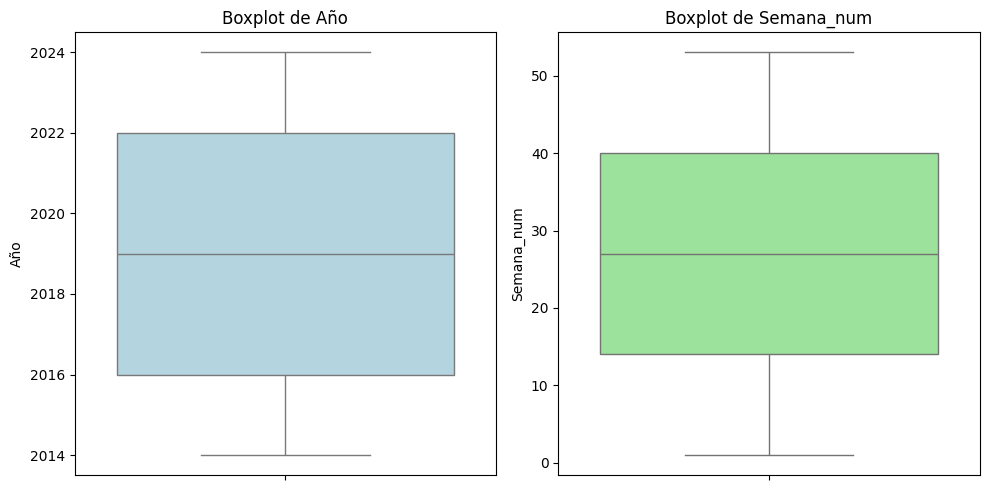

In [29]:
# Fila 1: Año y Semana_num
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=df_pivot["Año"], color="lightblue")
plt.title("Boxplot de Año")

plt.subplot(1, 2, 2)
sns.boxplot(y=df_pivot["Semana_num"], color="lightgreen")
plt.title("Boxplot de Semana_num")

plt.tight_layout()
plt.show()

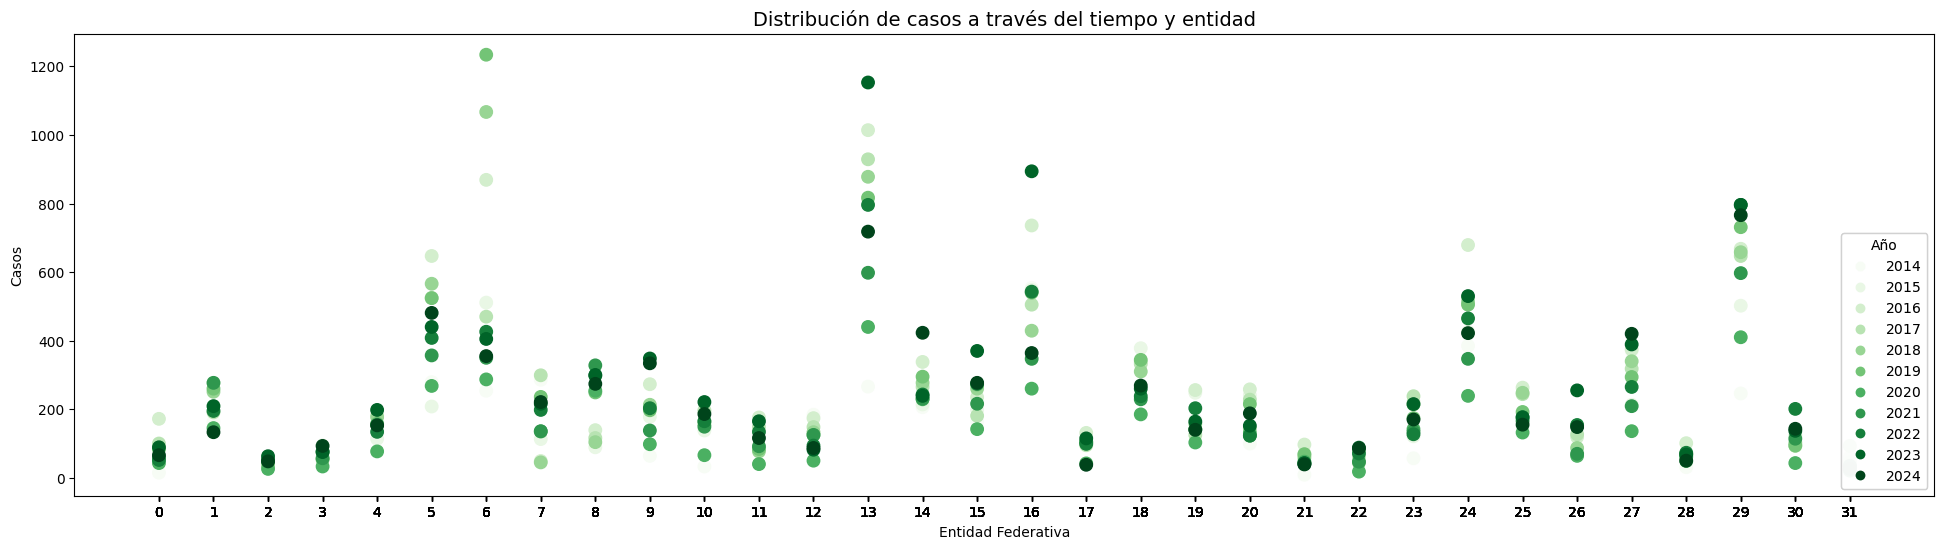

In [30]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_filtered = df.loc[df['Sexo'] == "SEM"]
df_filtered = df_filtered.groupby(by=['Año', 'Entidad']).agg(Casos=("Casos","sum")).reset_index()
y = df_filtered['Casos']
z = df_filtered['Año']
x = label_encoder.fit_transform(df_filtered['Entidad'])

fig, ax = plt.subplots( figsize = (24,6))

scatter = ax.scatter(x, y, c = z , cmap = 'Greens' , s = 80)
legend = ax.legend(*scatter.legend_elements(), loc="lower right",
                   title="Año")
ax.add_artist(legend)
ax.set_xlabel('Entidad Federativa')
ax.set_ylabel('Casos')
ax.set_title('Distribución de casos a través del tiempo y entidad', size = 14)
plt.xticks(x)
plt.show()

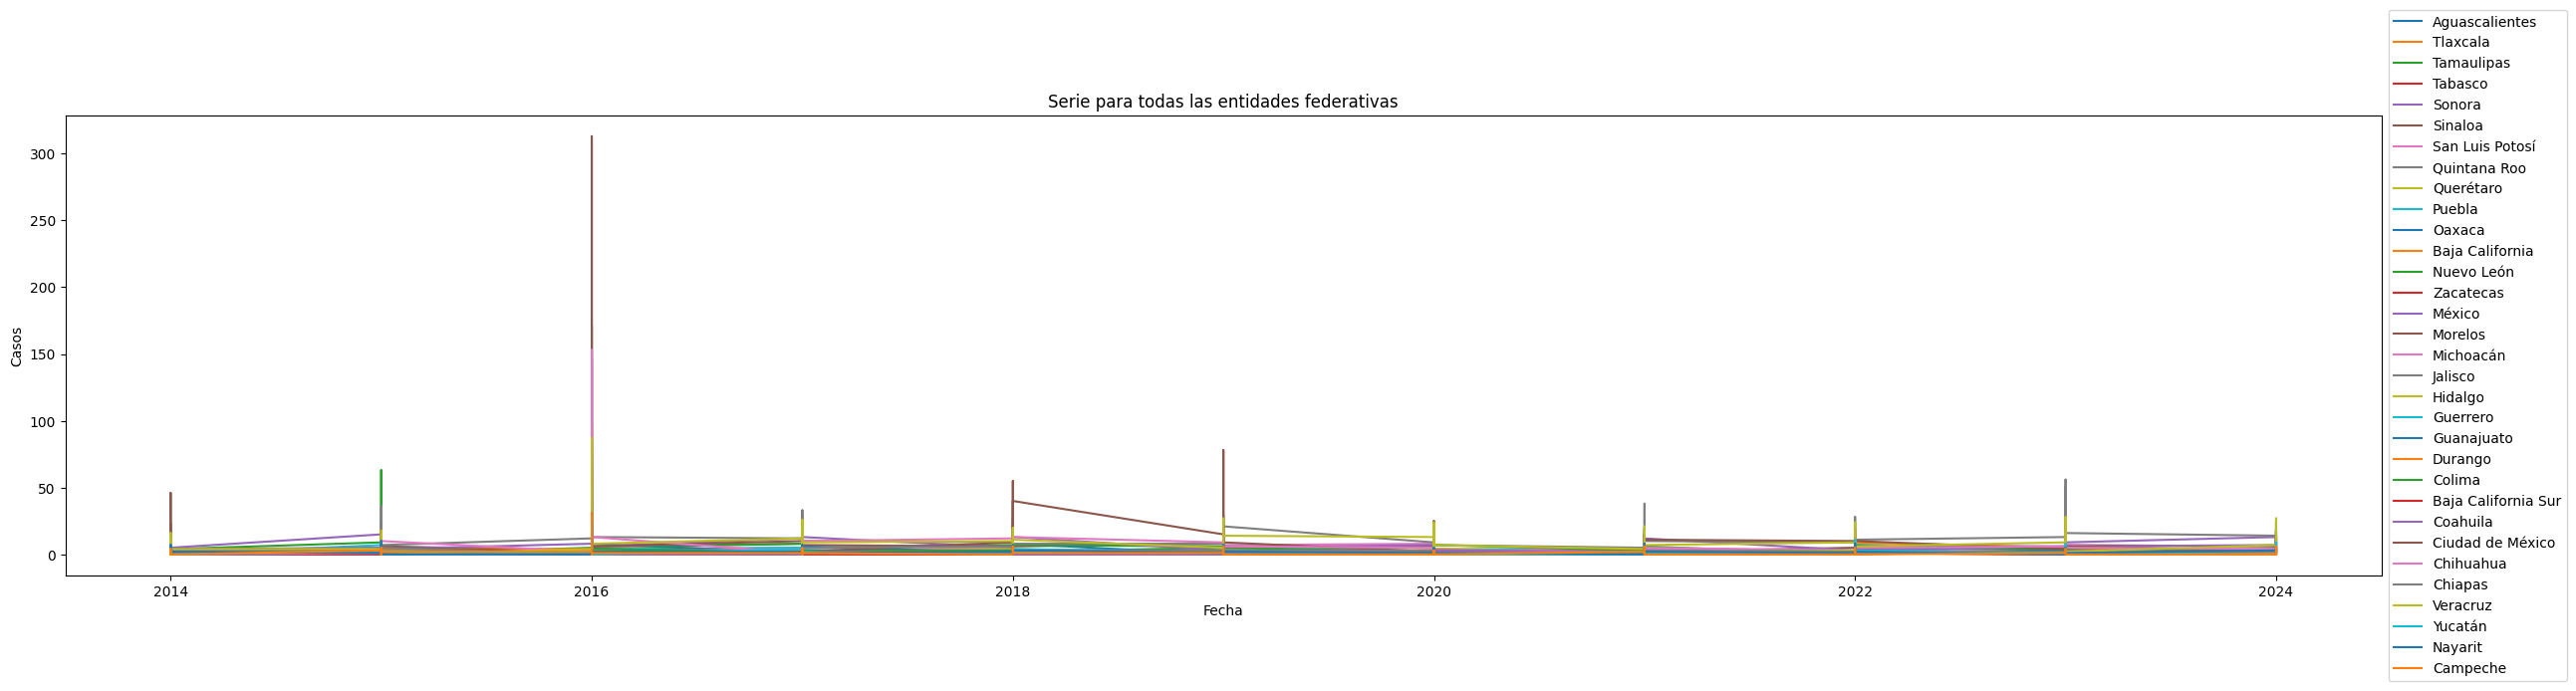

In [31]:
# Ejemplo de serie temporal para las entidades federativas
ej = df_pivot[
    (df_pivot["Padecimiento"].str.contains("Parkinson", case=False, na=False))
].sort_values("Fecha").copy()

if not ej.empty:
    plt.figure(figsize=(30,6))
    estados = ej["Entidad"].unique()
    for estado in estados:
      data = ej[(ej["Entidad"] == estado)]
      plt.plot(data["Año"], data["Nuevos_Casos"], label=estado)
    plt.title("Serie para todas las entidades federativas")
    plt.xlabel("Fecha"); plt.ylabel("Casos")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
    plt.show()

## Análisis Bivariado

### **¿Cómo se distribuyen los datos en función de diferentes categorías? (análisis bivariado)**

Se distribuyen por "Entidad", "Año" y "Sexo" (Acum_H y Acum_M) ya que son las variables principales que mostrarán como se comportan uno con la otra para poder realizar los análisis correspondientes y detectar si dos variables son dependientes una de la otra.

### Relación del estado con el número de casos totales

In [32]:
estado = {
   accepted: sub_df
   for accepted, sub_df in df_pivot.groupby("Entidad")[["Nuevos_Casos"]]
}

In [33]:
from scipy import stats
estados_list = []
for es in estado:
  estados_list.append(estado[es])
f_statistic, p_value = stats.f_oneway(*estados_list)
print(f'Estadístico F: {f_statistic}')
print(f'Valor p: {p_value}')

Estadístico F: [301.51583982]
Valor p: [0.]


### Relación del año con el número de casos por semana

In [34]:
años = {
   accepted: sub_df
   for accepted, sub_df in df_pivot.groupby("Año")[["Nuevos_Casos"]]
}

In [35]:
from scipy import stats
años_list = []
for a in años:
  años_list.append(años[a])
f_statistic, p_value = stats.f_oneway(*años_list)
print(f'Estadístico F: {f_statistic}')
print(f'Valor p: {p_value}')

Estadístico F: [42.0759249]
Valor p: [3.55636283e-83]


### Relación del sexo con el número de casos registrados semanalmente

In [36]:
df_filtered = df.loc[df['Sexo'] != "SEM"]
sexos = {
   accepted: sub_df
   for accepted, sub_df in df_filtered.groupby("Sexo")[["Casos"]]
}

In [37]:
from scipy import stats
sexos_list = []
for sex in sexos:
  sexos_list.append(sexos[sex])
f_statistic, p_value = stats.f_oneway(*sexos_list)
print(f'Estadístico F: {f_statistic}')
print(f'Valor p: {p_value}')

Estadístico F: [54.661292]
Valor p: [1.46256463e-13]


Al realizar un análisis enfocado en 2 variables, notamos que tanto para el año, el estado y el sexo, la variación o diferencia en ocurrencias de casos es bastante alta entre los datos, sin embargo, su valor P es bastante alto y de manera clara nos muestra que estas variables no son dependientes entre sí, ya que al ser un valor P alto, confirmamos la hipótesis nula de que los grupos de datos nos estan directamente relacionados con el número de casos de la enfermedad estudiada.

# Preguntas

### **9. ¿Se deberían normalizar las imágenes para visualizarlas mejor?**

NA. Esta pregunta no aplica en nuestro caso debido a que no se está trabajando con imagenes.

### **10. ¿Hay desequilibrio en las clases de la variable objetivo?**

NA. Esta pregunta tampoco aplica debido a que no estamos trabajando con un problema de clasificación, se está trabajando con variables que nos permitan predecir y conocer el aumento de casos de Parkinson en México.

****************************************************************************